# Check CREDIT z-score calculations

In [ ]:
import logging
import os
import sys
from glob import glob
from typing import Dict

import yaml
import numpy as np
import torch
from torchvision import transforms as tforms

from credit.data import ERA5_and_Forcing_Dataset, Sample, concat_and_reshape, reshape_only
from credit.transforms import Normalize_ERA5_and_Forcing, ToTensor_ERA5_and_Forcing, load_transforms
from credit.parser import CREDIT_main_parser, training_data_check

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# old rollout config
# config_name = '/glade/u/home/ksha/miles-physics/config/example_physics.yml'
# config_name = '/glade/work/ksha/CREDIT_runs/wxformer_1h/model_multi.yml'
# config_name = '/glade/work/ksha/CREDIT_runs/wxformer_physics_base/model_single_test.yml'
config_name = '/glade/work/ksha/CREDIT_runs/fuxi_physics_base/model_single.yml'

# Read YAML file
with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [4]:
conf = CREDIT_main_parser(conf, parse_training=True, parse_predict=False, print_summary=False)

In [5]:
rank = 0
world_size = 1

In [6]:
all_ERA_files = sorted(glob(conf["data"]["save_loc"]))

# check and glob surface files
if ('surface_variables' in conf['data']) and (len(conf['data']['surface_variables']) > 0):
    surface_files = sorted(glob(conf["data"]["save_loc_surface"]))

else:
    surface_files = None

# check and glob dyn forcing files
if ('dynamic_forcing_variables' in conf['data']) and (len(conf['data']['dynamic_forcing_variables']) > 0):
    dyn_forcing_files = sorted(glob(conf["data"]["save_loc_dynamic_forcing"]))

else:
    dyn_forcing_files = None

# check and glob diagnostic files
if ('diagnostic_variables' in conf['data']) and (len(conf['data']['diagnostic_variables']) > 0):
    diagnostic_files = sorted(glob(conf["data"]["save_loc_diagnostic"]))

else:
    diagnostic_files = None

# -------------------------------------------------- #
# import training / validation years from conf

if 'train_years' in conf['data']:
    train_years_range = conf['data']['train_years']
else:
    train_years_range = [1979, 2014]

if 'valid_years' in conf['data']:
    valid_years_range = conf['data']['valid_years']
else:
    valid_years_range = [2014, 2018]

# convert year info to str for file name search
train_years = [str(year) for year in range(train_years_range[0], train_years_range[1])]
valid_years = [str(year) for year in range(valid_years_range[0], valid_years_range[1])]

# Filter the files for training / validation
train_files = [file for file in all_ERA_files if any(year in file for year in train_years)]
valid_files = [file for file in all_ERA_files if any(year in file for year in valid_years)]

if surface_files is not None:

    train_surface_files = [file for file in surface_files if any(year in file for year in train_years)]
    valid_surface_files = [file for file in surface_files if any(year in file for year in valid_years)]
    
else:
    train_surface_files = None
    valid_surface_files = None

if dyn_forcing_files is not None:

    train_dyn_forcing_files = [file for file in dyn_forcing_files if any(year in file for year in train_years)]
    valid_dyn_forcing_files = [file for file in dyn_forcing_files if any(year in file for year in valid_years)]

else:
    train_dyn_forcing_files = None
    valid_dyn_forcing_files = None

if diagnostic_files is not None:

    train_diagnostic_files = [file for file in diagnostic_files if any(year in file for year in train_years)]
    valid_diagnostic_files = [file for file in diagnostic_files if any(year in file for year in valid_years)]

else:
    train_diagnostic_files = None
    valid_diagnostic_files = None

In [7]:
# --------------------------------------------------- #
is_train = False
# separate training set and validation set cases
if is_train:
    history_len = conf["data"]["history_len"]
    forecast_len = conf["data"]["forecast_len"]
    name = "training"
else:
    history_len = conf["data"]["valid_history_len"]
    forecast_len = conf["data"]["valid_forecast_len"]
    name = 'validation'

In [8]:
sst_forcing = {'varname_skt': conf['data']['sst_forcing']['varname_skt'], 
               'varname_ocean_mask': conf['data']['sst_forcing']['varname_ocean_mask']}

# sst_forcing = None

transforms = load_transforms(conf)

# totensor = ToTensor_ERA5_and_Forcing(conf)
# scaler_new = Normalize_ERA5_and_Forcing_new(conf)
# transforms = tforms.Compose([scaler_new, totensor])

# Z-score
dataset = ERA5_and_Forcing_Dataset(
    varname_upper_air=conf['data']['variables'],
    varname_surface=conf['data']['surface_variables'],
    varname_dyn_forcing=conf['data']['dynamic_forcing_variables'],
    varname_forcing=conf['data']['forcing_variables'],
    varname_static=conf['data']['static_variables'],
    varname_diagnostic=conf['data']['diagnostic_variables'],
    filenames=all_ERA_files,
    filename_surface=surface_files,
    filename_dyn_forcing=dyn_forcing_files,
    filename_forcing=conf['data']['save_loc_forcing'],
    filename_static=conf['data']['save_loc_static'],
    filename_diagnostic=diagnostic_files,
    history_len=history_len,
    forecast_len=forecast_len,
    skip_periods=conf["data"]["skip_periods"],
    one_shot=conf['data']['one_shot'],
    max_forecast_len=conf["data"]["max_forecast_len"],
    transform=transforms,
    sst_forcing=sst_forcing
)

In [9]:
batch_single = next(iter(dataset))

In [10]:
batch_single['x'].shape

torch.Size([2, 2, 13, 721, 1440])

In [11]:
batch = {}
keys = list(batch_single.keys())
keys = keys[:-1]
for var in keys:
    batch[var] = batch_single[var][None, ...]

In [12]:
if "x_surf" in batch:
    # combine x and x_surf
    # input: (batch_num, time, var, level, lat, lon), (batch_num, time, var, lat, lon)
    # output: (batch_num, var, time, lat, lon), 'x' first and then 'x_surf'
    x = concat_and_reshape(batch["x"], batch["x_surf"])
else:
    # no x_surf
    x = reshape_only(batch["x"])

# --------------------------------------------------------------------------------- #
# add forcing and static variables
if 'x_forcing_static' in batch:

    # (batch_num, time, var, lat, lon) --> (batch_num, var, time, lat, lon)
    x_forcing_batch = batch['x_forcing_static'].permute(0, 2, 1, 3, 4) #.float()

    # concat on var dimension
    x = torch.cat((x, x_forcing_batch), dim=1)

# --------------------------------------------------------------------------------- #
# combine y and y_surf
if "y_surf" in batch:
    y = concat_and_reshape(batch["y"], batch["y_surf"])
else:
    y = reshape_only(batch["y"])

if 'y_diag' in batch:

    # (batch_num, time, var, lat, lon) --> (batch_num, var, time, lat, lon)
    y_diag_batch = batch['y_diag'].permute(0, 2, 1, 3, 4) #.float()

    # concat on var dimension
    y = torch.cat((y, y_diag_batch), dim=1)

In [13]:
x.shape

torch.Size([1, 30, 2, 721, 1440])

In [14]:
y.shape

torch.Size([1, 31, 1, 721, 1440])

In [31]:
y.dtype

torch.float16

### Inverse norm verif

In [32]:
state_trans = load_transforms(conf, scaler_only=True)

x_inverse = state_trans.inverse_transform_input(x)
y_inverse = state_trans.inverse_transform(y)
y_norm = state_trans.transform_array(y_inverse)

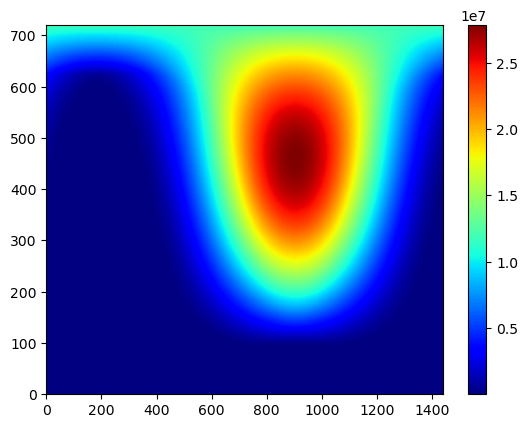

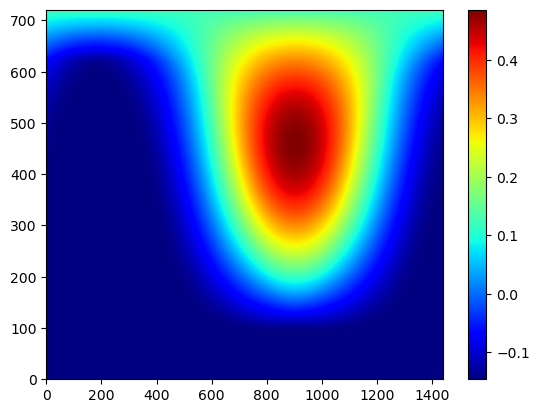

In [67]:
# y_norm - y
i_var = 68

plt.figure()
plt.pcolormesh(x_inverse[0, i_var, 0, ...], cmap=plt.cm.jet)
plt.colorbar()

plt.figure()
plt.pcolormesh(x[0, i_var, 0, ...], cmap=plt.cm.jet)
plt.colorbar()

In [18]:
y.shape

torch.Size([1, 81, 1, 721, 1440])

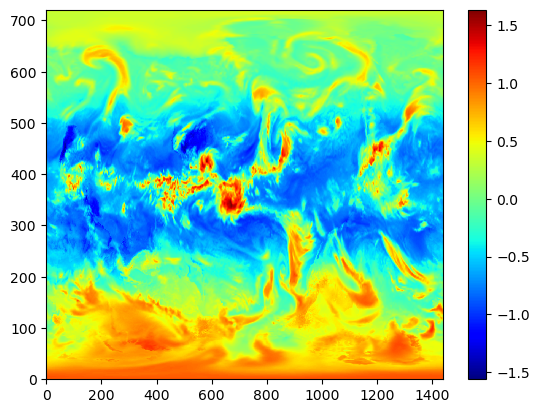

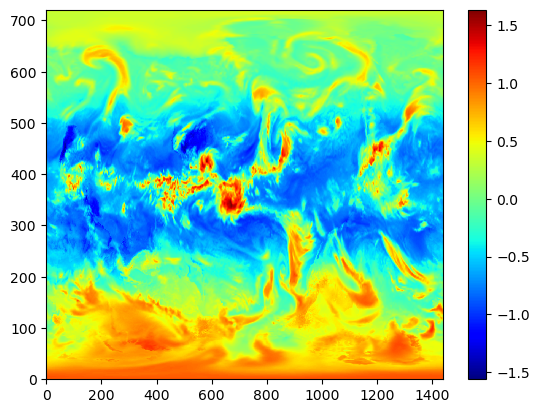

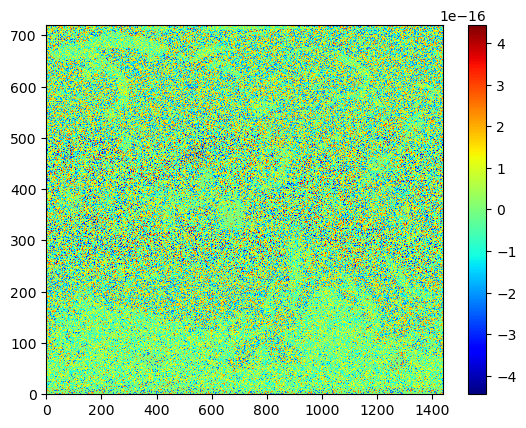

In [22]:
# y_norm - y
i_var = -1

plt.figure()
plt.pcolormesh(y[0, i_var, 0, ...], cmap=plt.cm.jet)
plt.colorbar()

plt.figure()
plt.pcolormesh(y_norm[0, i_var, 0, ...], cmap=plt.cm.jet)
plt.colorbar()

plt.figure()
plt.pcolormesh(y_norm[0, i_var, 0, ...]-y[0, i_var, 0, ...], cmap=plt.cm.jet)
plt.colorbar()